# Домашнее задание

ML разработчикам необходимо не только уметь обучать нейронные сети и генерировать новые идеи, но еще и уметь в страивать наработки в pipeline. В этом домашнем задании нам предстоит сделать из frustum детектора production ready (ну почти) решение, которое может работать на сырых данных.

К сожалению, frustum-pointnet работает независимо для каждой 2D детекции. В этом домашнем задании вам предстоит написать обертку над frustum-pointnet, которая будет работать над целыми облаками. Вам также нужно будет воспользоваться 2D детектором, чтобы находить коробки на изображении.

Во второй части задания вам нужно будет написать оценку качества работы вашего алгоритма, которая становится чуть сложнее, когда на сцене могут находится много объектов.

## Часть 1

Ниже написан класс, который вам нужно реализовать. Чтобы воспользоваться предобученной сетью, позаимствуйте код из
https://github.com/charlesq34/frustum-pointnets/blob/master/train/test.py

Предобученные модели лежат здесь: https://shapenet.cs.stanford.edu/media/frustum_pointnets_snapshots.zip

В частности, вам нужно модифицировать функцию `get_session_and_ops` - функция должна уметь работать без глобальных флагов. После этого посмотрите, как эта функция используется.
Выход сети преобразуется в понятный формат в функции `write_detection_results`.

In [1]:
import pickle
import cv2
import tensorflow as tf
from ssd import SSD, CAR_CLASS
from copy import deepcopy as dp
import numpy as np
import matplotlib.pylab as plt

In [2]:
from frustum_pointnets.kitti.kitti_object import * 
from frustum_pointnets.train.test import *
from frustum_pointnets.train.provider import * 

In [3]:
class FPnet:
    def __init__(self, batch_size=1, num_point=1024):
        self.batch_size = batch_size
        self.num_point = num_point
        self.sess, self.ops = get_session_and_ops(batch_size, num_point)
        
    def predict(self, pc, one_hot_vec):
        return inference(self.sess, self.ops, pc, one_hot_vec, self.batch_size)

In [4]:
detector = SSD('tmp')
fpn = FPnet()





The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators s

In [27]:
from collections import namedtuple

Detection = namedtuple('Detection', ['xyz', 'angle', 'lwh', 'confidence'])
Scene = namedtuple('Scene', ['detections'])

class PipelineDetector(object):
    def __init__(self, frustum_pointnet, frustum_batch_size, ssd_detector, ssd_threshold):
        self.frustum_pointnet = frustum_pointnet
        self.frustum_batch_size = frustum_batch_size
        self.ssd_detector = ssd_detector
        self.ssd_threshold = ssd_threshold
        self.one_hot_car = np.array([1.0, 0.0, 0.0])
    
    def predict(self, xyz, image, car_to_cam, intrinsics):
        boxes, fr_angles  = [], []
        
        prediction = self.ssd_detector.predict(image)
        num_detections = prediction['num_detections']
        one_hot_v = np.array([self.one_hot_car for _ in range(num_detections)])

        detection_scores = prediction['detection_scores'][:num_detections]
        detection_classes = prediction['detection_classes'][:num_detections]
        detection_boxes = prediction['detection_boxes'][:num_detections]

        query = (detection_classes == CAR_CLASS) & (detection_scores >= self.ssd_threshold)

        detection_scores = detection_scores[query]
        detection_classes = detection_classes[query]
        detection_boxes = detection_boxes[query]
        
        
        h, w, _ = image.shape
        points_3d = xyz[:,:-1]
        _, _, inds = get_lidar_in_image_fov(points_3d, car_to_cam, 0, 0, w, h, True)
        points_2d = car_to_cam.project_velo_to_image(dp(points_3d))
        
        for detection_box, detection_score, detection_class in zip(detection_boxes, detection_scores, detection_classes):
            
            ymin, xmin, ymax, xmax = detection_box * np.array([h, w, h, w])
            x_points_2d = points_2d[:, 0]
            y_points_2d = points_2d[:, -1]
            x_query = (xmin <= x_points_2d) & (xmax >= x_points_2d)
            y_query = (ymin <= y_points_2d) & (ymax >= y_points_2d)
            
            new_xyz = xyz[(x_query & y_query) & inds]
            
            uvdepth = np.zeros((1, 3))
            uvdepth[0, 0:2] = np.array([(xmin + xmax) / 2.0, (ymin + ymax) / 2.0])
            uvdepth[0, 2] = 20  
            box2d_center_rect = car_to_cam.project_image_to_rect(uvdepth)
            frustum_angle = np.pi / 2 - np.arctan2(box2d_center_rect[0, 2], box2d_center_rect[0, 0]) 
        
            
            np.random.seed(np.random.randint(int(1e5)))
            box = new_xyz[np.random.choice(len(new_xyz)-1, 1024, replace=True)]
            box[:, :-1] = dp(car_to_cam.project_velo_to_ref(box[:, :-1]))
            box[:, :-1] = dp(rotate_pc_along_y(box[:, :-1], frustum_angle))
            
            boxes.append(dp(box))
            fr_angles.append(frustum_angle)
        boxes = np.array(boxes)
        
        _, centers, heading_cls, heading_res, size_cls, size_res, scores = self.frustum_pointnet.predict(
                                                                                        boxes, 
                                                                                        one_hot_v)
        detections = []
        for i in range(num_detections):
            
            h, w, l, tx, ty, tz, ry = from_prediction_to_label_format(
                centers[i], 
                heading_cls[i], 
                heading_res[i], 
                size_cls[i], 
                size_res[i], 
                fr_angles[i])
            
            detection = Detection(xyz=np.array((tx, ty, tz)), 
                                  angle=ry, 
                                  lwh=np.array((l, w, h)), 
                                  confidence=detection_scores[i])
            
            detections.append(detection)
        return Scene(detections)

In [28]:
def get_ex(idx, data):
    image = data.get_image(idx)
    xyz = data.get_lidar(idx)
    car_to_cam = data.get_calibration(idx)
    labels = data.get_label_objects(idx)
    return image, xyz, car_to_cam, labels
    
data = kitti_object('kitti_dataset')
image, xyz, car_to_cam, labels = get_ex(21, data)

In [29]:
model = PipelineDetector(fpn, 1, detector, 0.5)
scene = model.predict(xyz, image, car_to_cam, _)
scene

Scene(detections=[Detection(xyz=array([-2.88134116,  1.70339746, 13.41805111]), angle=1.6716880370520273, lwh=array([3.87472351, 1.59131988, 1.51997019]), confidence=1.0), Detection(xyz=array([ 5.43880509,  1.57806458, 25.9246786 ]), angle=-1.525701954431383, lwh=array([3.78187493, 1.59179255, 1.48286955]), confidence=1.0), Detection(xyz=array([-1.37247079,  1.5780954 , 26.9542885 ]), angle=1.6683742681507994, lwh=array([3.92035652, 1.61717451, 1.58825437]), confidence=1.0), Detection(xyz=array([-2.410162  ,  1.55328178, 17.71049863]), angle=1.6288482191480704, lwh=array([4.20443953, 1.68799661, 1.72058272]), confidence=0.99728096)])

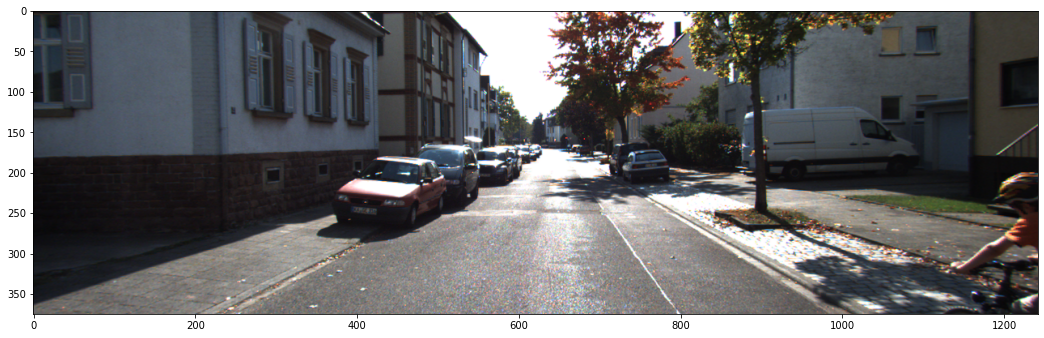

In [30]:
plt.figure(figsize=(18, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

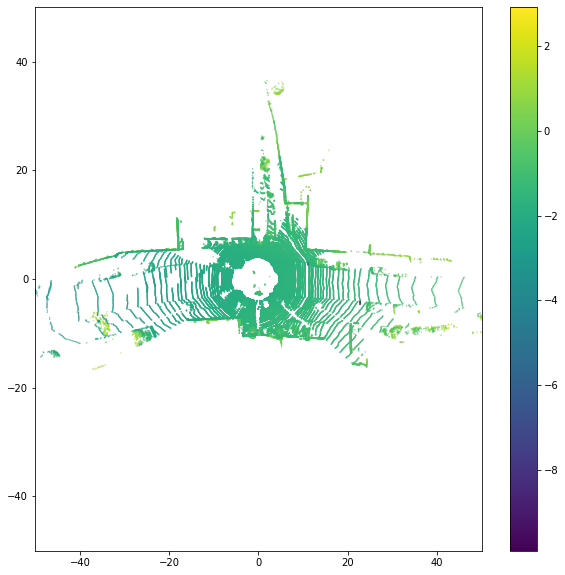

In [31]:
plt.figure(figsize=(10, 10))
plt.scatter(xyz[:, 0], xyz[:, 1], c=xyz[:, 2],  s=0.1)
plt.colorbar()
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.show()

### 2D детектор

В файле ssd.py есть детектор (файл называется ssd, но на самом деле там faster-rcnn), обученный на kitti. У него можно позвать predict на одном изображении. Коробки возвращаются в нормализованных координатах картинки. Класс 1 соответствует машинам, 2 - пешеходам.

## Часть 2

Для оценки качества работы 3D детекторов обычно используется average precision. Как измерить precision и recall детектора?

У каждой коробки детектора есть confidence. После того, как мы зафиксировали порог, у нас остается часть детекций.
Давайте теперь посмотрим на сцену сверху: bird's eye view. Забудем про координату z.

Далее мы можем посчитать IoU между всеми коробками ground truth и нашими детекциями.Давайте решим, что если IoU больше 0.7, то мы будем считать, что мы увидели gt коробку - относим эту детекцию к TP. Если gt не нашла пару - False Negative. Если детекция не нашла пару - False Positive.

Ваша задача написать код подсчета метрики average precision построенного детектора.

# Kitti Dataset
[Kitti dev-kit](https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip) : 
там можно найти описание данных и как преобразовывать данные между системами координат.

Homework KITTI dataset :https://www.icloud.com/iclouddrive/0bxlXWgCRTVvsWXmd-kcEqKqA#kitti_hw_dataset

In [39]:
import Image

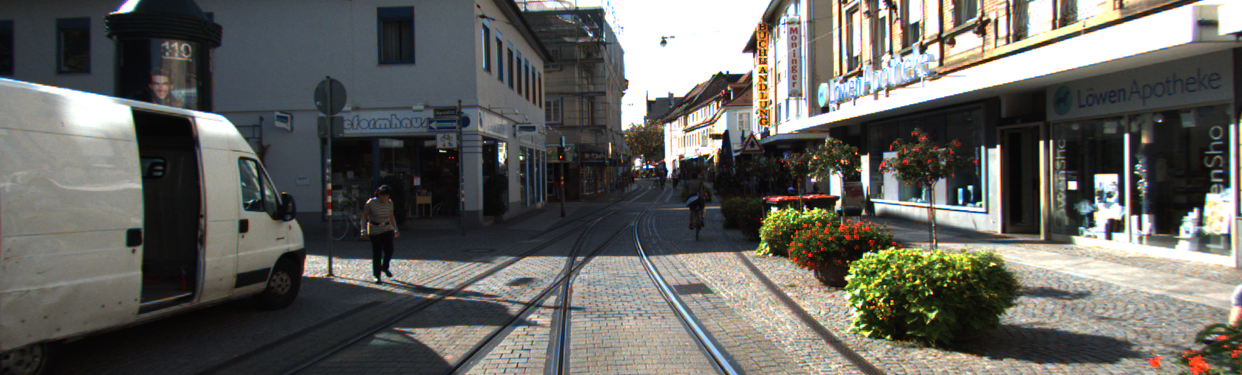

In [40]:
Image.open('../kitti_dataset/training/image_2/000100.png')

In [41]:
with open('../kitti_dataset/training/calib/000100.txt') as f:
    print f.read()

P0: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 0.000000000000e+00 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P1: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.875744000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P2: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 4.485728000000e+01 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.163791000000e-01 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.745884000000e-03
P3: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.395242000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.199936000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.729905000000e-03
R0_rect: 9.999239000000e-01 9.837760000000e-03 -7.445048000000e-03 -9.

In [45]:
with open('../kitti_dataset/training/label_2/000100.txt') as f:
    print f.read()

Van 0.63 0 -0.90 0.00 58.65 320.90 374.00 2.46 2.03 5.35 -5.18 1.69 7.24 -1.51
Cyclist 0.00 0 -1.58 684.31 165.66 710.23 242.31 1.82 0.59 1.89 2.13 1.66 18.06 -1.47
Pedestrian 0.00 0 0.84 359.32 182.26 400.32 285.85 1.57 0.52 0.62 -3.63 1.72 11.35 0.54
Car 0.00 2 -2.46 19.88 179.87 206.64 238.00 1.44 1.62 3.91 -13.04 1.64 18.98 -3.05
DontCare -1 -1 -10 650.19 158.35 666.90 192.77 -1 -1 -1 -1000 -1000 -1000 -10

